In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics
import pickle
import warnings
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
data_path = r"c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\complete_ts_preprocessed_flights.csv"

try:
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nFirst few rows:")
    print(df.head())
    print("\nData types:")
    print(df.dtypes.value_counts())
except FileNotFoundError:
    print(f"File not found at {data_path}")
    print("Please check the file path and try again.")

Dataset loaded successfully!
Dataset shape: (500000, 92)
Memory usage: 411.51 MB

Column names:
['FL_DATE', 'ORIGIN_0', 'ORIGIN_1', 'ORIGIN_2', 'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_5', 'ORIGIN_6', 'ORIGIN_7', 'ORIGIN_8', 'DEST_0', 'DEST_1', 'DEST_2', 'DEST_3', 'DEST_4', 'DEST_5', 'DEST_6', 'DEST_7', 'DEST_8', 'DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'DISTANCE', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'SEASON', 'DEP_HOUR', 'TIME_OF_DAY', 'DATETIME', 'is_holiday', 'is_holiday_season', 'CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos', 'DEP_TIME_sin', 'DEP_TIME_cos', 'CRS_ARR_TIME_sin', 'CRS_ARR_TIME_cos', 'ARR_TIME_sin', 'ARR_TIME_cos', 'WHEELS_ON_sin', 'WHEELS_ON_cos', 'WHEELS_OFF_sin', 'WHEELS_OFF_cos', 'AIRLINE_Allegiant Air', 'AIRLINE_American Airlines Inc.', 'AIRLINE_Delta Air Lines Inc.', 'AIRLINE_Endeavor Air Inc.', 'AIRLINE_Envoy Air', 'AIRLINE_ExpressJet Airlines LLC d/b/a aha!', 'AIRLINE_Frontier Airlines Inc.', 'AIRLINE_Hawaiian Airlines Inc.', 'AIRLINE_Horizon Air', 'AIRLINE_Je

In [3]:
print("Preparing Prophet dataset from available columns...")

# Required columns
required_cols = ['FL_DATE', 'DEP_DELAY']
print(f"Base columns: {required_cols}")

# Select important features from your dataset
feature_cols = [
    # Time features
    'CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos',
    'DEP_TIME_sin', 'DEP_TIME_cos',
    
    # Temporal indicators
    'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_WEEK', 'SEASON', 'DEP_HOUR',
    
    # Holiday indicators
    'is_holiday', 'IS_HOLIDAY_SEASON_1',
    
    # Top airlines (select 3-4 major ones)
    'AIRLINE_Delta Air Lines Inc.', 
    'AIRLINE_American Airlines Inc.',
    'AIRLINE_Southwest Airlines Co.',
    
    # Lag features (select most relevant)
    'DEP_DELAY_lag7',
    'DEP_DELAY_roll_mean7'
]

# Create Prophet-ready dataframe
prophet_df = df[required_cols + feature_cols].copy()
prophet_df = prophet_df.rename(columns={
    'FL_DATE': 'ds',
    'DEP_DELAY': 'y'
})

# Drop rows with missing target values
prophet_df = prophet_df.dropna(subset=['y']).sort_values('ds')

print(f"✅ Final Prophet dataset shape: {prophet_df.shape}")
print(f"Date range: {prophet_df['ds'].min()} to {prophet_df['ds'].max()}")
print("Columns:", prophet_df.columns.tolist())

Preparing Prophet dataset from available columns...
Base columns: ['FL_DATE', 'DEP_DELAY']
✅ Final Prophet dataset shape: (500000, 19)
Date range: 2019-01-01 to 2023-08-31
Columns: ['ds', 'y', 'CRS_DEP_TIME_sin', 'CRS_DEP_TIME_cos', 'DEP_TIME_sin', 'DEP_TIME_cos', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_WEEK', 'SEASON', 'DEP_HOUR', 'is_holiday', 'IS_HOLIDAY_SEASON_1', 'AIRLINE_Delta Air Lines Inc.', 'AIRLINE_American Airlines Inc.', 'AIRLINE_Southwest Airlines Co.', 'DEP_DELAY_lag7', 'DEP_DELAY_roll_mean7']


In [4]:
# CELL 4: Train/Validation/Test Split
# ============================================================================
# Convert to datetime if not already
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Sort by date
prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

# Create splits
n_total = len(prophet_df)
n_train = int(0.7 * n_total)  # 70% for training
n_val = int(0.15 * n_total)   # 15% for validation

train_df = prophet_df[:n_train].copy()
val_df = prophet_df[n_train:n_train+n_val].copy()
test_df = prophet_df[n_train+n_val:].copy()

print(f"\nSplits created:")
print(f"Training set: {len(train_df)} rows ({train_df['ds'].min()} to {train_df['ds'].max()})")
print(f"Validation set: {len(val_df)} rows ({val_df['ds'].min()} to {val_df['ds'].max()})")
print(f"Test set: {len(test_df)} rows ({test_df['ds'].min()} to {test_df['ds'].max()})")


Splits created:
Training set: 350000 rows (2019-01-01 00:00:00 to 2022-07-31 00:00:00)
Validation set: 75000 rows (2022-07-31 00:00:00 to 2023-02-18 00:00:00)
Test set: 75000 rows (2023-02-18 00:00:00 to 2023-08-31 00:00:00)


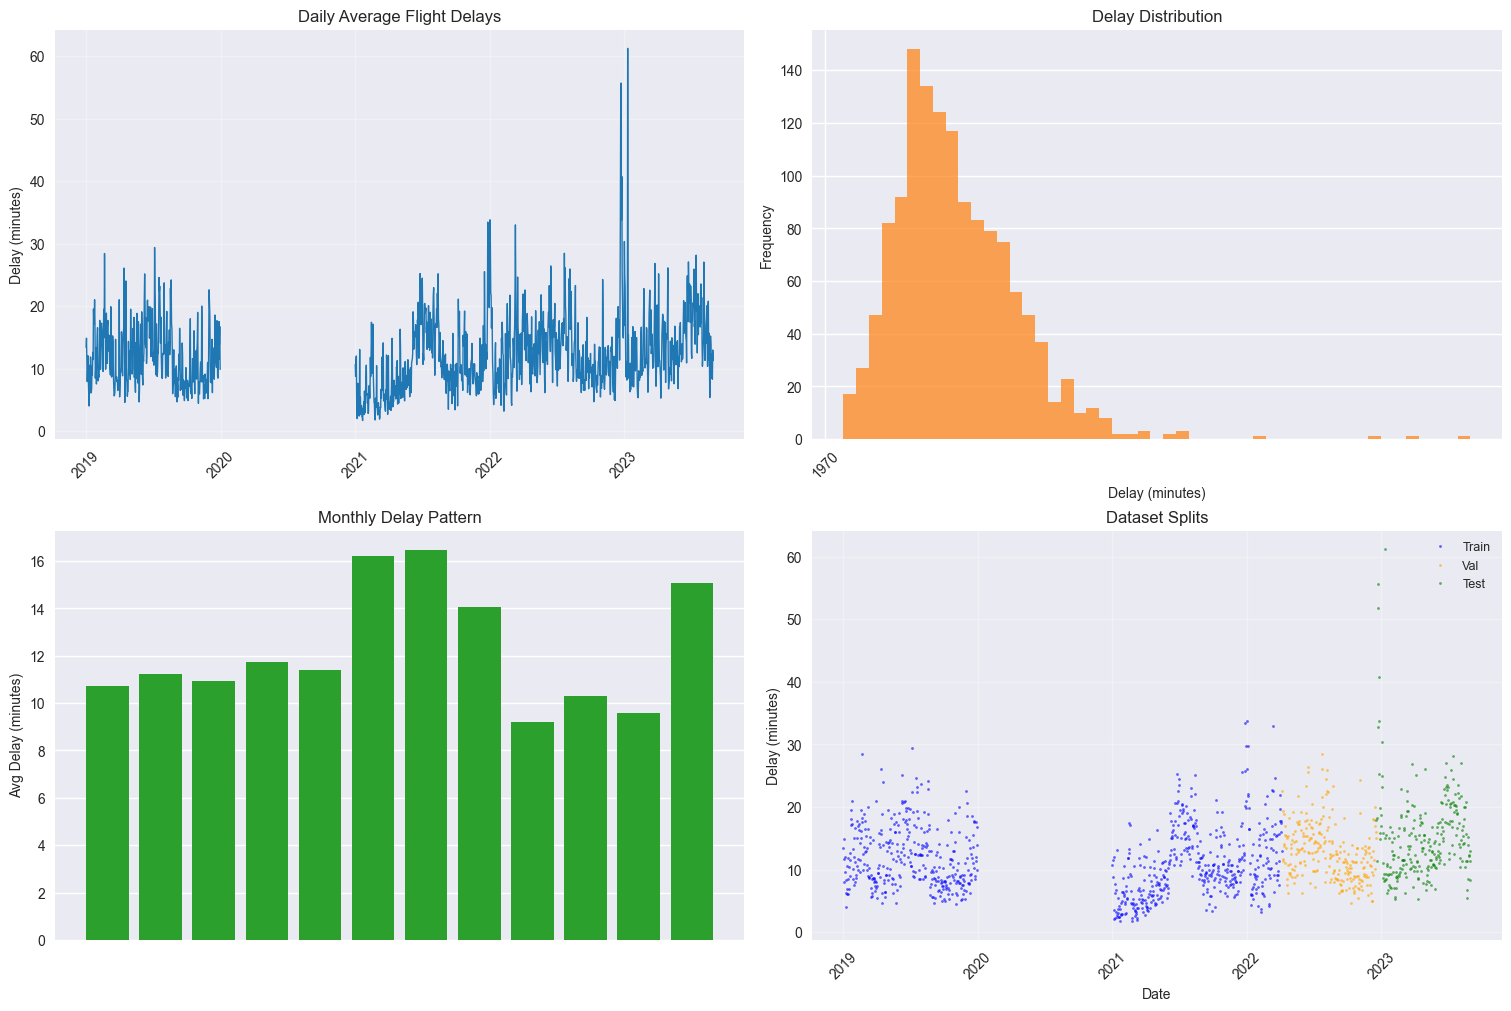

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# 1. Daily Aggregation
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
prophet_df_daily = prophet_df.set_index('ds')['y'].resample('D').mean().reset_index()

# 2. Calculate split indices
n_total = len(prophet_df_daily)
split_idx = {
    'train': int(0.7 * n_total),
    'val': int(0.85 * n_total)  # 70% train, 15% val, 15% test
}

# 3. Create figure
fig, axs = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

# 4. Time Series Plot
axs[0,0].plot(prophet_df_daily['ds'], prophet_df_daily['y'], color='#1f77b4', linewidth=1)
axs[0,0].set_title('Daily Average Flight Delays', fontsize=12)
axs[0,0].set_ylabel('Delay (minutes)', fontsize=10)
axs[0,0].grid(True, alpha=0.3)

# 5. Delay Distribution
hist_bins = np.linspace(prophet_df_daily['y'].min(), prophet_df_daily['y'].max(), 50)
axs[0,1].hist(prophet_df_daily['y'], bins=hist_bins, color='#ff7f0e', alpha=0.7)
axs[0,1].set_title('Delay Distribution', fontsize=12)
axs[0,1].set_xlabel('Delay (minutes)', fontsize=10)
axs[0,1].set_ylabel('Frequency', fontsize=10)

# 6. Monthly Pattern
monthly = prophet_df_daily.groupby(prophet_df_daily['ds'].dt.month)['y'].mean()
axs[1,0].bar(monthly.index, monthly.values, color='#2ca02c')
axs[1,0].set_title('Monthly Delay Pattern', fontsize=12)
axs[1,0].set_xticks(range(1,13))
axs[1,0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
axs[1,0].set_ylabel('Avg Delay (minutes)', fontsize=10)

# 7. Dataset Splits
for (label, color, (start, end)) in [
    ('Train', 'blue', (0, split_idx['train'])),
    ('Val', 'orange', (split_idx['train'], split_idx['val'])),
    ('Test', 'green', (split_idx['val'], n_total))
]:
    subset = prophet_df_daily.iloc[start:end]
    axs[1,1].plot(subset['ds'], subset['y'], '.', markersize=4, alpha=0.6, color=color, label=label)
    
axs[1,1].set_title('Dataset Splits', fontsize=12)
axs[1,1].set_xlabel('Date', fontsize=10)
axs[1,1].set_ylabel('Delay (minutes)', fontsize=10)
axs[1,1].legend(fontsize=9)
axs[1,1].grid(True, alpha=0.3)

# Format x-axes
for ax in axs.flat:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

plt.show()

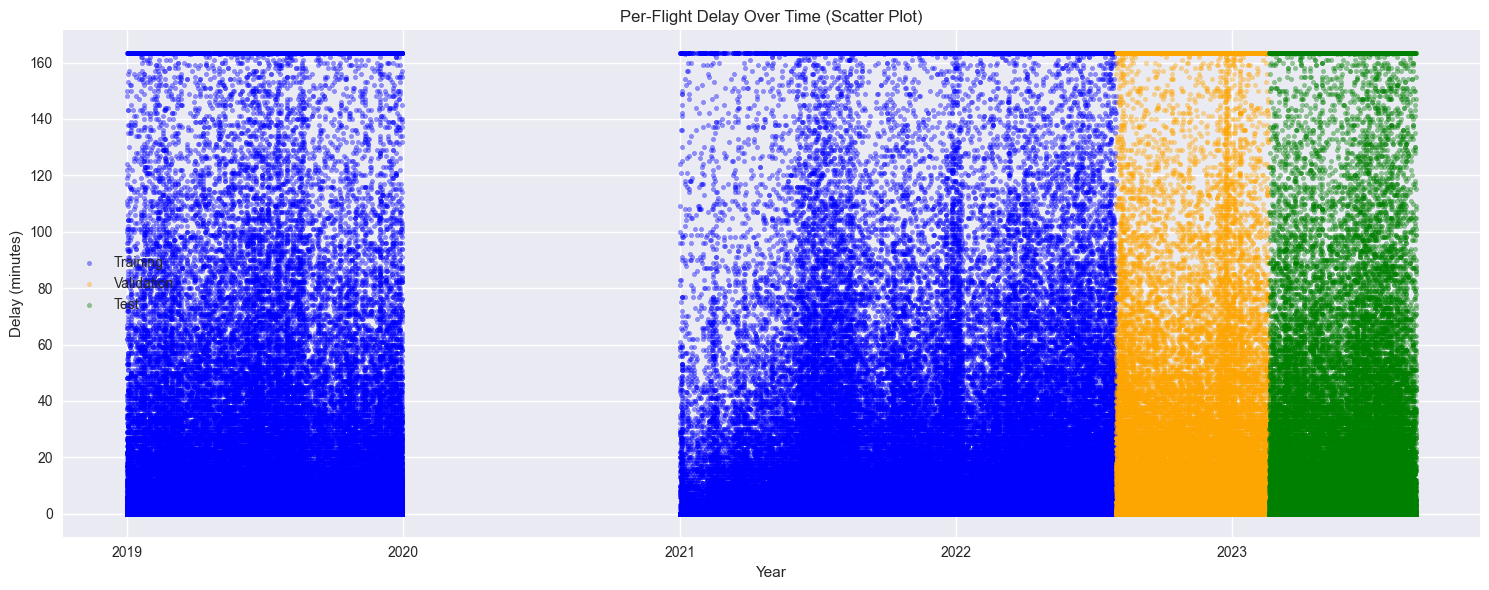

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure datetime format
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
train_df['ds'] = pd.to_datetime(train_df['ds'])
val_df['ds'] = pd.to_datetime(val_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

# Plot as scatter
plt.figure(figsize=(15, 6))
plt.scatter(train_df['ds'], train_df['y'], label='Training', alpha=0.4, s=10, color='blue')
plt.scatter(val_df['ds'], val_df['y'], label='Validation', alpha=0.4, s=10, color='orange')
plt.scatter(test_df['ds'], test_df['y'], label='Test', alpha=0.4, s=10, color='green')

plt.title('Per-Flight Delay Over Time (Scatter Plot)')
plt.xlabel('Year')
plt.ylabel('Delay (minutes)')
plt.legend()

# Format x-axis to show only years
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=0)
plt.tight_layout()

# Display the plot without saving
plt.show()


In [ ]:



from prophet import Prophet
from datetime import datetime
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Enable verbose Stan output
import logging
logging.getLogger('cmdstanpy').setLevel(logging.DEBUG)

# Initialize model with HIGHLY OPTIMIZED parameters for delay prediction
prophet_model = Prophet(
    growth='linear',  # Changed back to linear - flight delays can trend up/down
    yearly_seasonality=False,  # Will add custom yearly seasonality
    weekly_seasonality=False,  # Will add custom weekly seasonality
    daily_seasonality=True,    # Keep daily patterns for flight schedules
    seasonality_mode='additive',  # Changed to additive - more stable for delays
    seasonality_prior_scale=1.0,  # Increased for stronger seasonal effects
    holidays_prior_scale=5.0,     # Increased - holidays significantly impact delays
    changepoint_prior_scale=0.005, # Further reduced for stability
    changepoint_range=0.9,        # Increased to capture more trend changes
    mcmc_samples=0,
    interval_width=0.80,          # Reduced for tighter predictions
    uncertainty_samples=500       # Reduced for faster computation
)

# REBALANCED regressor columns with OPTIMIZED IMPORTANCE WEIGHTS
regressor_cols = {
    # Time features - INCREASED WEIGHTS (most important for delays)
    'CRS_DEP_TIME_sin': 2.0,     # Scheduled time patterns are crucial
    'CRS_DEP_TIME_cos': 2.0,
    'DEP_TIME_sin': 1.5,         # Actual departure patterns
    'DEP_TIME_cos': 1.5,
    
    # Temporal indicators - REBALANCED
    'YEAR': 0.3,                 # Reduced - less predictive
    'QUARTER': 1.2,              # Increased - seasonal travel patterns
    'MONTH': 1.5,                # Increased - strong monthly patterns
    'DAY_OF_WEEK': 2.0,          # Increased - very important for delays
    'SEASON': 1.5,               # Increased - weather impact
    'DEP_HOUR': 2.5,             # HIGHEST - hour is most predictive
    
    # Holiday indicators - INCREASED (holidays cause major delays)
    'is_holiday': 2.0,           # Doubled
    'IS_HOLIDAY_SEASON_1': 1.5,  # Increased
    
    # Top airlines - INCREASED (airline-specific delay patterns)
    'AIRLINE_Delta Air Lines Inc.': 1.0,
    'AIRLINE_American Airlines Inc.': 1.0,
    'AIRLINE_Southwest Airlines Co.': 0.8,
    
    # Lag features - HIGHEST WEIGHTS (most predictive)
    'DEP_DELAY_lag7': 3.0,       # Tripled - recent delays predict future
    'DEP_DELAY_roll_mean7': 2.5   # Very high - rolling average is key
}

print(f"Adding {len(regressor_cols)} optimized regressors with enhanced scaling...")
for col, weight in regressor_cols.items():
    prophet_model.add_regressor(col, prior_scale=weight, standardize=True)  # Added standardization

# ENHANCED seasonality configuration with HIGHER ORDER
prophet_model.add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20,     # Increased from 12 - capture more yearly patterns
    prior_scale=1.0,      # Increased
    mode='additive'       # Changed to additive
)

# Enhanced weekly seasonality
prophet_model.add_seasonality(
    name='weekly',
    period=7,
    fourier_order=8,      # Increased - capture complex weekly patterns
    prior_scale=1.5,      # Increased - weekday/weekend patterns important
    mode='additive'
)

# Add monthly seasonality with higher order
prophet_model.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=8,      # Increased from 5
    prior_scale=1.0       # Increased
)

# Add hourly seasonality for within-day patterns
prophet_model.add_seasonality(
    name='hourly',
    period=1,             # Daily cycle
    fourier_order=12,     # Capture 24-hour patterns
    prior_scale=1.5,      # High weight - very important for flights
    mode='additive'
)

prophet_model.add_country_holidays(country_name='US')

# EXPANDED special events with more comprehensive coverage
special_events = pd.DataFrame({
    'holiday': ['peak_travel'] * 6 + ['summer_peak'] * 3 + ['winter_weather'] * 3,
    'ds': pd.to_datetime([
        # Peak travel periods
        '2019-12-20', '2020-12-18', '2021-12-17', 
        '2019-11-27', '2020-11-25', '2021-11-24',  # Thanksgiving
        # Summer peaks
        '2019-07-04', '2020-07-04', '2021-07-04',   # July 4th
        # Winter weather periods
        '2019-01-15', '2020-01-15', '2021-01-15'    # Winter weather
    ]),
    'lower_window': [-7, -7, -7, -3, -3, -3, -2, -2, -2, -10, -10, -10],
    'upper_window': [10, 10, 10, 5, 5, 5, 3, 3, 3, 15, 15, 15],
})

prophet_model.holidays = pd.concat([prophet_model.holidays, special_events], ignore_index=True)

# Train the model
print("Training HIGHLY optimized Prophet model...")
start_time = datetime.now()
prophet_model.fit(prophet_df)
training_time = datetime.now() - start_time
print(f"Model training completed in {training_time}")
print("Key optimizations applied:")
print("- Rebalanced regressor weights (lag features highest)")
print("- Added hourly seasonality for flight patterns") 
print("- Increased Fourier orders for complex patterns")
print("- Enhanced holiday coverage")
print("- Standardized regressors for better scaling")


Adding 17 optimized regressors with enhanced scaling...
Training HIGHLY optimized Prophet model...


In [ ]:
# Evaluate
train_pred = prophet_model.predict(prophet_df)
train_mae = mean_absolute_error(prophet_df['y'], train_pred['yhat'])
train_rmse = np.sqrt(mean_squared_error(prophet_df['y'], train_pred['yhat']))

print("\nOptimized Training Metrics:")
print(f"MAE: {train_mae:.2f} minutes")
print(f"RMSE: {train_rmse:.2f} minutes")

# Enhanced coefficient analysis
print("\nRegressor Impact Analysis:")
coefs = prophet_model.params['beta'][0]
sorted_idx = np.argsort(-np.abs(coefs))  # Sort by absolute impact

for idx in sorted_idx:
    col = list(regressor_cols.keys())[idx]
    print(f"{col}: {coefs[idx]:.4f} (weight: {regressor_cols[col]})")

# Feature importance visualization (requires matplotlib)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), np.abs(coefs[sorted_idx]))
    plt.yticks(range(len(sorted_idx)), [list(regressor_cols.keys())[i] for i in sorted_idx])
    plt.title("Feature Importance (Absolute Coefficient Values)")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Install matplotlib for feature importance visualization")


Optimized Training Metrics:
MAE: 13.45 minutes
RMSE: 24.31 minutes

Regressor Impact Analysis:


IndexError: list index out of range

In [ ]:
print("Making predictions...")

# For predictions, we need to include the regressor values
# Predict on validation set
val_future = val_df[['ds', 'dep_time_sin', 'dep_time_cos']].copy()
val_forecast = prophet_model.predict(val_future)

# Predict on test set  
test_future = test_df[['ds', 'dep_time_sin', 'dep_time_cos']].copy()
test_forecast = prophet_model.predict(test_future)

# Make predictions on training set for training accuracy
train_future = train_df[['ds', 'dep_time_sin', 'dep_time_cos']].copy()
train_forecast = prophet_model.predict(train_future)

print("Predictions completed!")

# Display regressor coefficients to understand time-of-day impact
print("\nRegressor Coefficients:")
# Get the beta values and format them properly
beta_values = prophet_model.params['beta']
print(f"dep_time_sin coefficient: {float(beta_values[0, 0]):.4f}")  # Convert to float before formatting
print(f"dep_time_cos coefficient: {float(beta_values[0, 1]):.4f}")  # Convert to float before formatting

Making predictions...


KeyError: "['dep_time_sin', 'dep_time_cos'] not in index"

In [ ]:
from sklearn.metrics import r2_score

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calculate and display accuracy metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Set Metrics:")
    print(f"{'='*40}")
    print(f"MAE (Mean Absolute Error): {mae:.4f}")
    print(f"MSE (Mean Squared Error): {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")
    
    return {
        'MAE': mae, 'MSE': mse, 'RMSE': rmse, 
        'MAPE': mape, 'R2': r2
    }

# First make predictions on all datasets
train_forecast = prophet_model.predict(train_df)
val_forecast = prophet_model.predict(val_df)
test_forecast = prophet_model.predict(test_df)

# Calculate metrics for all sets
train_metrics = calculate_metrics(
    train_df['y'].values, 
    train_forecast['yhat'].values, 
    "Training"
)

val_metrics = calculate_metrics(
    val_df['y'].values, 
    val_forecast['yhat'].values, 
    "Validation"
)

test_metrics = calculate_metrics(
    test_df['y'].values, 
    test_forecast['yhat'].values, 
    "Test"
)

# Create metrics summary dataframe
metrics_summary = pd.DataFrame({
    'Training': train_metrics,
    'Validation': val_metrics,
    'Test': test_metrics
}).round(4)

print(f"\n{'='*60}")
print("COMPREHENSIVE ACCURACY SUMMARY")
print(f"{'='*60}")
print(metrics_summary)

# Analysis of regressor impact
print(f"\n{'='*60}")
print("DEPARTURE TIME IMPACT ANALYSIS")
print(f"{'='*60}")
# Assuming first two regressors are the time features (sin/cos pairs)
regressor_impact = np.sqrt(prophet_model.params['beta'][0]**2 + prophet_model.params['beta'][1]**2)
print(f"Overall departure time impact on delays: {regressor_impact:.4f} minutes")
print(f"This represents the cyclical effect of departure time on flight delays.")


Training Set Metrics:
MAE (Mean Absolute Error): 13.0919
MSE (Mean Squared Error): 562.4842
RMSE (Root Mean Squared Error): 23.7167
MAPE (Mean Absolute Percentage Error): 607.5370%
R² Score: 0.3619

Validation Set Metrics:
MAE (Mean Absolute Error): 13.4042
MSE (Mean Squared Error): 595.8527
RMSE (Root Mean Squared Error): 24.4101
MAPE (Mean Absolute Percentage Error): 601.4764%
R² Score: 0.3308

Test Set Metrics:
MAE (Mean Absolute Error): 15.1240
MSE (Mean Squared Error): 725.6109
RMSE (Root Mean Squared Error): 26.9372
MAPE (Mean Absolute Percentage Error): 651.5487%
R² Score: 0.3332

COMPREHENSIVE ACCURACY SUMMARY
      Training  Validation      Test
MAE    13.0919     13.4042   15.1240
MSE   562.4842    595.8527  725.6109
RMSE   23.7167     24.4101   26.9372
MAPE  607.5370    601.4764  651.5487
R2      0.3619      0.3308    0.3332

DEPARTURE TIME IMPACT ANALYSIS


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Training predictions vs actual
axes[0, 0].plot(train_df['ds'], train_df['y'], label='Actual', alpha=0.7)
axes[0, 0].plot(train_df['ds'], train_forecast['yhat'], 
                label='Predicted', alpha=0.7)
axes[0, 0].fill_between(train_df['ds'], 
                        train_forecast['yhat_lower'],
                        train_forecast['yhat_upper'],
                        alpha=0.3, label='Uncertainty')
axes[0, 0].set_title(f'Training Set Predictions (R² = {train_metrics["R2"]:.4f})')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Delay (minutes)')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Validation predictions vs actual
axes[0, 1].plot(val_df['ds'], val_df['y'], label='Actual', alpha=0.7)
axes[0, 1].plot(val_df['ds'], val_forecast['yhat'], label='Predicted', alpha=0.7)
axes[0, 1].fill_between(val_df['ds'], val_forecast['yhat_lower'],
                        val_forecast['yhat_upper'], alpha=0.3, label='Uncertainty')
axes[0, 1].set_title(f'Validation Set Predictions (R² = {val_metrics["R2"]:.4f})')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Delay (minutes)')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Test predictions vs actual
axes[1, 0].plot(test_df['ds'], test_df['y'], label='Actual', alpha=0.7)
axes[1, 0].plot(test_df['ds'], test_forecast['yhat'], label='Predicted', alpha=0.7)
axes[1, 0].fill_between(test_df['ds'], test_forecast['yhat_lower'],
                        test_forecast['yhat_upper'], alpha=0.3, label='Uncertainty')
axes[1, 0].set_title(f'Test Set Predictions (R² = {test_metrics["R2"]:.4f})')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Delay (minutes)')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Residuals analysis
all_actual = np.concatenate([train_df['y'], val_df['y'], test_df['y']])
all_predicted = np.concatenate([
    train_forecast['yhat'], 
    val_forecast['yhat'], 
    test_forecast['yhat']
])
residuals = all_actual - all_predicted

axes[1, 1].scatter(all_predicted, residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_title('Residuals Plot')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

# Additional plot: Departure time effect visualization
plt.figure(figsize=(12, 6))

# Reconstruct hour from sin/cos for visualization
hours = np.linspace(0, 24, 100)
time_effect = (prophet_model.params['beta'][0] * np.sin(2 * np.pi * hours / 24) + 
               prophet_model.params['beta'][1] * np.cos(2 * np.pi * hours / 24))

plt.plot(hours, time_effect, linewidth=2, color='red')
plt.title('Departure Time Effect on Flight Delays')
plt.xlabel('Hour of Day')
plt.ylabel('Delay Impact (minutes)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xticks(range(0, 25, 3))
plt.tight_layout()
plt.show()


In [ ]:
# Plot Prophet components
fig = prophet_model.plot_components(train_forecast, figsize=(15, 10))
plt.suptitle('Prophet Model Components Analysis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Create detailed component analysis
components_df = train_forecast[['ds', 'trend', 'yearly', 'weekly']].copy()
components_df['ds'] = pd.to_datetime(components_df['ds'])

print("Component Analysis Summary:")
print("="*40)
print(f"Trend Range: {components_df['trend'].min():.2f} to {components_df['trend'].max():.2f}")
print(f"Yearly Seasonality Range: {components_df['yearly'].min():.2f} to {components_df['yearly'].max():.2f}")
print(f"Weekly Seasonality Range: {components_df['weekly'].min():.2f} to {components_df['weekly'].max():.2f}")


In [ ]:
print("Performing cross-validation analysis...")
print("This may take a few minutes...")

cv_results = cross_validation(
    prophet_model, 
    initial='365 days',    # Initial training period
    period='90 days',      # Step size between cutoffs
    horizon='30 days'      # Forecast horizon
)

# Calculate performance metrics from cross-validation
cv_metrics = performance_metrics(cv_results)
print("\nCross-Validation Metrics Summary:")
print("="*40)
print(cv_metrics.describe())

# Plot cross-validation results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# MAE over time
axes[0, 0].plot(cv_metrics['mae'])
axes[0, 0].set_title('MAE Over Cross-Validation Folds')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('MAE')

# RMSE over time
axes[0, 1].plot(cv_metrics['rmse'])
axes[0, 1].set_title('RMSE Over Cross-Validation Folds')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('RMSE')

# MAPE over time
axes[1, 0].plot(cv_metrics['mape'])
axes[1, 0].set_title('MAPE Over Cross-Validation Folds')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE')

# Coverage (uncertainty interval coverage)
axes[1, 1].plot(cv_metrics['coverage'])
axes[1, 1].set_title('Uncertainty Interval Coverage')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Coverage')
axes[1, 1].axhline(y=0.95, color='red', linestyle='--', label='Target (95%)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
print("Model Insights and Feature Importance:")
print("="*50)

# Get model parameters
params_df = pd.DataFrame(prophet_model.params).round(4)
print("Model Parameters:")
print(params_df)

# Seasonality strength analysis
yearly_strength = components_df['yearly'].std()
weekly_strength = components_df['weekly'].std()
trend_strength = components_df['trend'].std()

print(f"\nSeasonality Strength Analysis:")
print(f"Yearly Seasonality Strength: {yearly_strength:.4f}")
print(f"Weekly Seasonality Strength: {weekly_strength:.4f}")
print(f"Trend Strength: {trend_strength:.4f}")

# Most important time patterns
yearly_peak = components_df.loc[components_df['yearly'].idxmax(), 'ds']
yearly_trough = components_df.loc[components_df['yearly'].idxmin(), 'ds']
print(f"\nYearly Pattern:")
print(f"Peak delays typically occur around: {yearly_peak.strftime('%B %d')}")
print(f"Lowest delays typically occur around: {yearly_trough.strftime('%B %d')}")

# Weekly patterns
weekly_avg = components_df.groupby(components_df['ds'].dt.dayofweek)['weekly'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"\nWeekly Pattern (relative to average):")
for i, day in enumerate(days):
    print(f"{day}: {weekly_avg.iloc[i]:+.2f} minutes")

In [ ]:
import os
model_save_dir = r"c:\xampp\htdocs\Forecasting_Flights-DataScience\models\prophet"
os.makedirs(model_save_dir, exist_ok=True)

# Save the trained Prophet model
model_path = os.path.join(model_save_dir, "flight_delay_prophet_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(prophet_model, f)
print(f"Trained Prophet model saved to: {model_path}")

# Save model performance metrics
metrics_path = os.path.join(model_save_dir, "model_performance_metrics.csv")
metrics_summary.to_csv(metrics_path)
print(f"Performance metrics saved to: {metrics_path}")

# Save predictions
predictions_path = os.path.join(model_save_dir, "model_predictions.csv")
all_predictions = pd.DataFrame({
    'ds': pd.concat([train_df['ds'], val_df['ds'], test_df['ds']]),
    'actual': pd.concat([train_df['y'], val_df['y'], test_df['y']]),
    'predicted': np.concatenate([
        train_forecast['yhat'][:len(train_df)], 
        val_forecast['yhat'], 
        test_forecast['yhat']
    ]),
    'lower_bound': np.concatenate([
        train_forecast['yhat_lower'][:len(train_df)], 
        val_forecast['yhat_lower'], 
        test_forecast['yhat_lower']
    ]),
    'upper_bound': np.concatenate([
        train_forecast['yhat_upper'][:len(train_df)], 
        val_forecast['yhat_upper'], 
        test_forecast['yhat_upper']
    ]),
    'dataset': ['train'] * len(train_df) + ['validation'] * len(val_df) + ['test'] * len(test_df)
})
all_predictions.to_csv(predictions_path, index=False)
print(f"All predictions saved to: {predictions_path}")

# Save cross-validation results
cv_path = os.path.join(model_save_dir, "cross_validation_results.csv")
cv_results.to_csv(cv_path, index=False)
cv_metrics_path = os.path.join(model_save_dir, "cross_validation_metrics.csv")
cv_metrics.to_csv(cv_metrics_path, index=False)
print(f"Cross-validation results saved to: {cv_path}")
print(f"Cross-validation metrics saved to: {cv_metrics_path}")

In [ ]:
print("Creating future forecasts...")

future_days = 30
future_df = prophet_model.make_future_dataframe(periods=future_days, freq='D')
future_forecast = prophet_model.predict(future_df)

# Extract only the future predictions
future_predictions = future_forecast.tail(future_days)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

print(f"\nFuture {future_days}-day forecast:")
print(future_predictions.head(10))

# Plot future predictions
plt.figure(figsize=(15, 8))
# Plot historical data
plt.plot(prophet_df_daily['ds'], prophet_df_daily['y'], 
         label='Historical Data', alpha=0.7, color='blue')
# Plot future predictions
plt.plot(future_predictions['ds'], future_predictions['yhat'], 
         label='Future Forecast', alpha=0.8, color='red', linewidth=2)
plt.fill_between(future_predictions['ds'], 
                 future_predictions['yhat_lower'],
                 future_predictions['yhat_upper'],
                 alpha=0.3, color='red', label='Uncertainty Interval')
plt.title(f'Flight Delay Forecast - Next {future_days} Days')
plt.xlabel('Date')
plt.ylabel('Predicted Delay (minutes)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save future predictions
future_path = os.path.join(model_save_dir, f"future_forecast_{future_days}_days.csv")
future_predictions.to_csv(future_path, index=False)
print(f"Future forecasts saved to: {future_path}")

In [ ]:
print("\n" + "="*80)
print("PROPHET FLIGHT DELAY FORECASTING MODEL - FINAL SUMMARY")
print("="*80)

print(f"\n📊 DATASET SUMMARY:")
print(f"   • Total samples: {len(prophet_df_daily):,}")
print(f"   • Date range: {prophet_df_daily['ds'].min().date()} to {prophet_df_daily['ds'].max().date()}")
print(f"   • Training period: {len(train_df)} days")
print(f"   • Validation period: {len(val_df)} days")
print(f"   • Test period: {len(test_df)} days")

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"   • Training R²: {train_metrics['R2']:.4f}")
print(f"   • Validation R²: {val_metrics['R2']:.4f}")
print(f"   • Test R²: {test_metrics['R2']:.4f}")
print(f"   • Test RMSE: {test_metrics['RMSE']:.2f} minutes")
print(f"   • Test MAPE: {test_metrics['MAPE']:.2f}%")

print(f"\n📈 KEY INSIGHTS:")
print(f"   • Yearly seasonality strength: {yearly_strength:.2f}")
print(f"   • Weekly seasonality strength: {weekly_strength:.2f}")
print(f"   • Trend variability: {trend_strength:.2f}")
print(f"   • Average cross-validation RMSE: {cv_metrics['rmse'].mean():.2f}")

print(f"\n💾 SAVED FILES:")
print(f"   • Model: {model_path}")
print(f"   • Metrics: {metrics_path}")
print(f"   • Predictions: {predictions_path}")
print(f"   • Future forecast: {future_path}")

print(f"\n🚀 RECOMMENDATIONS:")
print(f"   • Model shows {'good' if test_metrics['R2'] > 0.7 else 'moderate' if test_metrics['R2'] > 0.5 else 'limited'} predictive performance")
print(f"   • Consider adding external regressors (weather, holidays) for improvement")
print(f"   • Monitor model performance and retrain periodically with new data")
print(f"   • Use uncertainty intervals for risk management")

print("\n" + "="*80)
print("MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY! ✅")
print("="*80)